In [ ]:
#Part of this notebook is based on https://github.com/kristinakobrock/context-shapes-language
from utils.load_results import *
from utils.plot_helpers import *

import pandas as pd
#import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')
import torch
from utils.analysis_from_interaction import *
from language_analysis_local import TopographicSimilarityConceptLevel, encode_target_concepts_for_topsim
import os
if not os.path.exists('analysis'):
    os.makedirs('analysis')
#import plotly.express as px

In [2]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
n_epochs = 300
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [3]:
context_unaware = False # whether original or context_unaware simulations are evaluated

setting = 'standard'
granularity_list = ['coarse', 'mixed', 'fine']
non_default_gran_list = ['coarse', 'fine']

### Determine vocab size

In [5]:
import os
import csv
from collections import Counter

# Define the directory and filename for the CSV file
output_folder = 'analysis'
csv_filename = os.path.join(output_folder, '00_vocab_sizes.csv')

# Check if the output folder exists, if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Check if the CSV file exists, if not, create it with headers
fieldnames = ['dataset', 'context_condition', 'vocab_size', 'symbols']
file_exists = os.path.exists(csv_filename)
with open(csv_filename, 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()

# Open the file in append mode and write the vocab sizes for each dataset
with open(csv_filename, 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Go through all datasets
    for i, d in enumerate(datasets):
        for g in granularity_list:
            # select first run
            if g != 'mixed':
                path_to_run = paths[i] + '/' + str(setting) + '/' + 'granularity_' + g + '/' + str(0) + '/'
                path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
                interaction = torch.load(path_to_interaction_train)
                
                messages = interaction.message.argmax(dim=-1)
                messages = [msg.tolist() for msg in messages]
                all_symbols = [symbol for message in messages for symbol in message]
                symbol_counts = Counter(all_symbols)
                vocab_size = len(symbol_counts)

            elif g == 'mixed':
                path_to_run = paths[i] + '/' + str(setting) + '/' + str(0) + '/'
                path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
                interaction = torch.load(path_to_interaction_train)
                
                messages = interaction.message.argmax(dim=-1)
                messages = [msg.tolist() for msg in messages]
                all_symbols = [symbol for message in messages for symbol in message]
                symbol_counts = Counter(all_symbols)
                vocab_size = len(symbol_counts)
            
            writer.writerow({'dataset': d, 'context_condition': g, 'vocab_size': vocab_size, 'symbols': symbol_counts})


In [ ]:
import pandas as pd
df = pd.read_csv('analysis/00_vocab_sizes.csv')
df

### See which messages are produced for which concepts

In [ ]:
# go through all datasets
for i, d in enumerate(datasets):
    for g in non_default_gran_list:
        if g != 'mixed':
        # select first run
            path_to_run = paths[i] + '/' + str(setting) +'/granularity_' + g +'/' + str(0) + '/'
        else:
            path_to_run = paths[i] + '/' + str(setting) +'/' + str(0) + '/'
            
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        interaction = torch.load(path_to_interaction_train)
        print(path_to_interaction_train)

        messages = interaction.message.argmax(dim=-1)
        messages = [msg.tolist() for msg in messages]
        sender_input = interaction.sender_input
        print(sender_input.shape)
        n_targets = int(sender_input.shape[1]/2)
        # get target objects and fixed vectors to re-construct concepts
        target_objects = sender_input[:, :n_targets]
        target_objects = k_hot_to_attributes(target_objects, n_values[i])
        # concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
        (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
        concepts = list(zip(objects, fixed))

        # get distractor objects to re-construct context conditions
        distractor_objects = sender_input[:, n_targets:]
        distractor_objects = k_hot_to_attributes(distractor_objects, n_values[i])
        context_conds = retrieve_context_condition(objects, fixed, distractor_objects)
        #print(context_conds)

        # get random qualitative samples
        #fixed_index = random.randint(0, n_attributes[i]-1) # define a fixed index for the concept
        n_fixed = random.randint(1, n_attributes[i]) # how many fixed attributes?
        #n_fixed = 3
        fixed_indices = random.sample(range(0, n_attributes[i]), k=n_fixed) # select which attributes are fixed
        #fixed_indices = [0, 2, 1]
        #fixed_value = random.randint(0, n_values[i]-1) # define a fixed value for this index
        fixed_values = random.choices(range(0, n_values[i]), k=n_fixed)
        #fixed_values = [0, 1, 2]
        print(n_fixed, fixed_indices, fixed_values)
        #index_threshold = 20000 # optional: define some index threshold to make sure that examples are not taken from the beginning of training
        # TODO: adapt this loop such that multiple indices can be fixed
        all_for_this_concept = []
        for idx, (t_objects, t_fixed) in enumerate(concepts):
            #if sum(t_fixed) == 1 and t_fixed[fixed_index] == 1:# and idx > index_threshold:
            if sum(t_fixed) == n_fixed and all(t_fixed[fixed_index] == 1 for fixed_index in fixed_indices):
                for t_object in t_objects:
                    if all(t_object[fixed_index] == fixed_values[j] for j, fixed_index in enumerate(fixed_indices)):
                        all_for_this_concept.append((idx, t_object, t_fixed, context_conds[idx], messages[idx]))
                        fixed = t_fixed
        #print(all_for_this_concept)                
        if len(all_for_this_concept) > 0:
            #sample = random.sample(all_for_this_concept, 20)
            sample = all_for_this_concept
            column_names = ['game_nr', 'object', 'fixed indices', 'context condition', 'message']
            df = pd.DataFrame(sample, columns=column_names)
            df.to_csv('analysis/quali_' + str(d) + '_' + str(setting) + '_'+g +'_' + str(sample[0][1]) + ',' + str(fixed) + 'all.csv', index=False)
            print('saved ' + 'analysis/quali_' + str(d) + '_' + str(setting) +'_' + g + '_' + str(sample[0][1]) + ',' + str(fixed) + 'all.csv')
        else:
            raise ValueError("sample for dataset " + str(d) + g + " could not be generated")

### Count messages used for each dataset

In [4]:
def create_alternative_representation(concept):
        '''
        this function allows to create an alternative represenation for concepts that is completely aequivent to the one 
        used until now, but may come in handy for comparisons bewteen concepts.

        Args:
            concept : a concept is the form usual form (objects, fixed)
        
        Returns:
            tuple : the same concept in an alternative represenation, where non-fixed attributes are represented as '?'.

        Examples:
           >>> create_alternative_represenantion(([(1, 2, 2), (1, 2, 1), (1, 2, 0)], (1, 1, 0)))
            (1, 2, '?')
        '''
        obj, fixed = concept
        new_obj = [
            value if is_fixed else '?' 
            for value, is_fixed in zip(obj, fixed)
        ]
        #rep = (((new_obj), (fixed)))
        rep = tuple(new_obj)

        return rep

In [186]:

import csv
import os
import torch

# Define the directory and filename for the CSV file
analysis_folder = 'analysis'
csv_filename = os.path.join(analysis_folder, 'message_counts.csv')

fieldnames = ['dataset', 'context_condition', 'unique_messages', 'unique_concepts', 'messages/concepts']

# Check if the CSV file exists, if not, create it with headers
if not os.path.exists(csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

# Go through all datasets
for i, d in enumerate(datasets):
    for g in granularity_list:
        if g != 'mixed':
      # select first run
            path_to_run = paths[i] + '/' + str(setting) + '/granularity_' + g + '/' + str(0) + '/'
        else:
            path_to_run = paths[i] + '/' + str(setting) +'/' + str(0) + '/'

        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        interaction = torch.load(path_to_interaction_train)
        #print(path_to_interaction_train)

        messages = interaction.message.argmax(dim=-1)
        messages = [msg.tolist() for msg in messages]
        unique_messages = set(tuple(msg) for msg in messages)  # Convert lists to tuples before adding to the set
       
       
        sender_input = interaction.sender_input
        n_targets = int(sender_input.shape[1] / 2)
        
        # Get target objects and fixed vectors to re-construct concepts
        target_objects = sender_input[:, :n_targets]
        target_objects = k_hot_to_attributes(target_objects, n_values[i])
        # Concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
        (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
        concepts = list(zip(objects, fixed))

        concept_reps= []

        for idx, (t_objects, t_fixed) in enumerate(concepts):
            #concept_sample = (tuple(t_objects[0]), tuple(t_fixed))
            concept_sample = (
                    list(int(x) for x in t_objects[0]), 
                    list(int(x) for x in t_fixed)
                )
            #mess.append(tuple(messages[idx]))
            concept_reps.append(create_alternative_representation(concept_sample))
        
        unique_concepts = set(concept_reps)


        concept_count = len(unique_concepts)
        mess_count = len(unique_messages)
        # Check if the combination of dataset and context condition already exists in the CSV file
        combination_exists = False
        with open(csv_filename, 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['dataset'] == d and row['context_condition'] == g:
                    combination_exists = True
                    break

        # If the combination exists, update the corresponding row
        if combination_exists:
            rows = []
            with open(csv_filename, 'r', newline='') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    if row['dataset'] == d and row['context_condition'] == g:
                        row['unique_messages'] = mess_count
                        row['unique_concepts'] = concept_count
                        row['messages/concepts'] = mess_count/concept_count
                    rows.append(row)
            
            with open(csv_filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(rows)
        # If the combination does not exist, append a new row
        else:
            with open(csv_filename, 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerow({'dataset': d, 'context_condition': g, 'unique_messages': mess_count, 'unique_concepts': concept_count, 'messages/concepts': mess_count/concept_count})

In [ ]:
import pandas as pd
df = pd.read_csv('analysis/message_counts.csv')
df

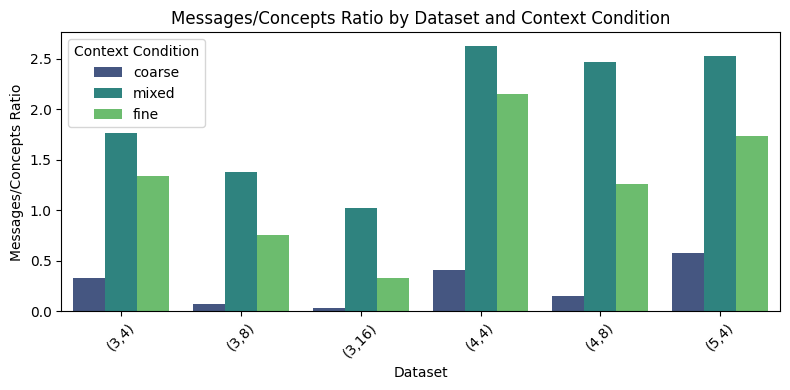

In [4]:
### Display the number of messages that were used during tranining in each ocntext condition as a bar plot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('analysis/message_counts.csv')

# Convert the 'dataset' column to a string type for better visualization
data['dataset'] = data['dataset'].astype(str)

# Set the figure size for better readability
plt.figure(figsize=(8, 4))

# Create a bar plot
sns.barplot(x='dataset', y='messages/concepts', hue='context_condition', data=data, palette='viridis')

# Add titles and labels
plt.title('Messages/Concepts Ratio by Dataset and Context Condition')
plt.xlabel('Dataset')
plt.ylabel('Messages/Concepts Ratio')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Context Condition')
plt.show()

## Concepts and messages

### Explorative analysis

In [ ]:
# change this to generate samples for a specific granularity
granularity = 'coarse'


# go through all datasets
for i, d in enumerate(datasets):
        # select first run
        path_to_run = paths[i] + '/' + str(setting) +'/granularity_' + granularity +'/' + str(0) + '/'
            
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        interaction = torch.load(path_to_interaction_train)
        print(path_to_interaction_train)

        messages = interaction.message.argmax(dim=-1)
        messages = [msg.tolist() for msg in messages]
        sender_input = interaction.sender_input
        print(sender_input.shape)
        n_targets = int(sender_input.shape[1]/2)
        # get target objects and fixed vectors to re-construct concepts
        target_objects = sender_input[:, :n_targets]
        target_objects = k_hot_to_attributes(target_objects, n_values[i])
        # concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
        (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
        concepts = list(zip(objects, fixed))

        # get distractor objects to re-construct context conditions
        distractor_objects = sender_input[:, n_targets:]
        distractor_objects = k_hot_to_attributes(distractor_objects, n_values[i])
        context_conds = retrieve_context_condition(objects, fixed, distractor_objects)
        #print(context_conds)

        # get random qualitative samples
        #fixed_index = random.randint(0, n_attributes[i]-1) # define a fixed index for the concept
        #n_fixed = random.randint(1, n_attributes[i]) # how many fixed attributes?
        n_fixed =1
        #fixed_indices = random.sample(range(0, n_attributes[i]), k=n_fixed) # select which attributes are fixed
        fixed_indices = [0]
        #fixed_value = random.randint(0, n_values[i]-1) # define a fixed value for this index
        #fixed_values = random.choices(range(0, n_values[i]), k=n_fixed)
        fixed_values = [2]
        print(n_fixed, fixed_indices, fixed_values)
        #index_threshold = 20000 # optional: define some index threshold to make sure that examples are not taken from the beginning of training
        # TODO: adapt this loop such that multiple indices can be fixed
        all_for_this_concept = []
        for idx, (t_objects, t_fixed) in enumerate(concepts):
            #if sum(t_fixed) == 1 and t_fixed[fixed_index] == 1:# and idx > index_threshold:
            if sum(t_fixed) == n_fixed and all(t_fixed[fixed_index] == 1 for fixed_index in fixed_indices):
                for t_object in t_objects:
                    if all(t_object[fixed_index] == fixed_values[j] for j, fixed_index in enumerate(fixed_indices)):
                        all_for_this_concept.append((idx, t_object, t_fixed, context_conds[idx], messages[idx]))
                        fixed = t_fixed
        #print(all_for_this_concept)                
        if len(all_for_this_concept) > 0:
            #sample = random.sample(all_for_this_concept, 20)
            sample = all_for_this_concept
            column_names = ['game_nr', 'object', 'fixed indices', 'context condition', 'message']
            df = pd.DataFrame(sample, columns=column_names)
            df.to_csv('analysis/quali_' + str(d) + '_' + str(setting) + '_'+granularity +'_' + str(sample[0][1]) + ',' + str(fixed) + 'all.csv', index=False)
            print('saved ' + 'analysis/quali_' + str(d) + '_' + str(setting) +'_' + granularity+ '_' + str(sample[0][1]) + ',' + str(fixed) + 'all.csv')
        else:
            raise ValueError("sample for dataset " + str(d) + granularity + " could not be generated")

### Concepts for given messages in coarse context condition

In [8]:
import ast
def concepts_for_message(df, messages):
    '''this function displays all unique concepts that were referred to by a set of messages. 
       The option of giving more that one message can be useful to make a qualitative (and non-exahustive)
       first analysis of whether the languae may display positional features

    Args
        df (pandas dataframe) : dataframe conatning all the messages used during the last epoch of training and the concepts they were
                                used to refer to. These dataframes can be found under 'analysis\messages'
        messages (list[tuple]) 

    Returns
        list[tuple] : all the concepts that the messages were used to refer to
    '''
    concepts = []
    for message in messages:
        ex = df[df['message'] == str(message)]

        # Extract the concepts from the matching row
        concepts_str = ex.iloc[0, 1]
        # Convert the string representation of the tuple of lists to a Python object (tuple of lists)
        concepts_lists = ast.literal_eval(concepts_str)
        #immutable_data = [(tuple(item1), tuple(item2)) for item1, item2 in concepts_lists]
        #unique_concepts= list(immutable_data)
        for concept_tuple in set(concepts_lists):
            concepts.append(concept_tuple)
    return concepts

In [141]:
import torch
import pandas as pd
import random

# Assuming these variables are already defined: datasets, paths, setting, non_default_gran_list, n_epochs, n_values, n_attributes


# Go through all datasets
for i, d in enumerate(datasets):
    path_to_run = paths[i] + '/' + str(setting) + '/granularity_coarse' + '/' + str(0) + '/'
    
    path_to_interaction_train = path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0'
    path_to_interaction_val = path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0'
    interaction = torch.load(path_to_interaction_train)
    #print("Interaction train path:", path_to_interaction_train)

    messages = interaction.message.argmax(dim=-1)
    messages = [msg.tolist() for msg in messages]
    sender_input = interaction.sender_input
    #print("Sender input shacpe:", sender_input.shape)
    n_targets = int(sender_input.shape[1] / 2)
    
    # Get target objects and fixed vectors to re-construct concepts
    target_objects = sender_input[:, :n_targets]
    target_objects = k_hot_to_attributes(target_objects, n_values[i])
    # Concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
    (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
    concepts = list(zip(objects, fixed))
    #print(concepts[0])

   # Collect data for the DataFrame

    mess = []
    concept_reps= []

    for idx, (t_objects, t_fixed) in enumerate(concepts):
        concept_sample = (
                list(int(x) for x in t_objects[0]), 
                list(int(x) for x in t_fixed)
            )
        mess.append(tuple(messages[idx]))
        concept_reps.append(create_alternative_representation(concept_sample))

    # Create the DataFrame
    df = pd.DataFrame({'concepts': concept_reps, 'message': mess})
    concept_df = df.groupby('concepts').agg({'message': lambda x: list(x)})
    print(concept_df.shape)

    # Group by messages and aggregate concepts
    message_df = df.groupby('message', as_index=False).agg({'concepts': lambda x:list(x)})
    message_df.to_csv('analysis/messages/'+str(d) + '_' + str(setting) + '_granularity_coarse.csv', index=False)
    

(99, 1)
(582, 1)
(3929, 1)
(499, 1)
(5248, 1)
(2499, 1)


### D(3,4)

In [73]:
# Load DataFrame from CSV file
df = pd.read_csv('analysis/messages/(3,4)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(4,4,4,0),]):
    print(c)

### fixed 1 is 1st postion 

(1, '?', 1)
(1, 0, 1)
(1, 3, 2)
(1, 1, 0)
(1, 1, '?')
(1, '?', '?')
(1, 1, 3)
(1, 0, '?')
(1, 3, 1)
(1, '?', 0)
(1, 1, 2)
(1, 3, '?')
(1, 0, 0)
(1, 3, 3)
(1, 3, 0)
(1, 0, 2)
(1, 1, 1)


In [74]:
import ast
import pandas as pd

# Load DataFrame from CSV file
df = pd.read_csv('analysis/messages/(3,4)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(14,14,14,0),]):
    print(c)


## fixed 2 in second position

(2, 2, 2)
(0, 2, '?')
(3, 2, 1)
(1, 2, 2)
(2, 2, '?')
(0, 2, 1)
(1, 2, '?')
('?', 2, '?')
(2, 2, 1)
(3, 2, 0)
(1, 2, 1)
(3, 2, 3)
(0, 2, 0)
('?', 2, 1)
(0, 2, 3)
(2, 2, 0)
(1, 2, 0)
(3, 2, 2)
('?', 2, 3)
(3, 2, '?')


In [75]:

# Load DataFrame from CSV file
df = pd.read_csv('analysis/messages/(3,4)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(9,9,9,0),]):
    print(c)
## fixed 0 in first position whaaaaat

(0, 0, '?')
(0, 1, 0)
(0, 1, 3)
(0, 3, 0)
(0, 3, 3)
(0, '?', 1)
(0, 0, 1)
(0, 1, 2)
(0, '?', 0)
(0, '?', 3)
(0, 3, 2)
(0, 1, '?')
(0, 0, 0)
(0, 3, '?')
(0, 2, 3)
(0, 1, 1)
(0, 3, 1)
(0, '?', 2)
(0, 0, 2)
(0, '?', '?')


In [76]:
import ast
import pandas as pd

# Load DataFrame from CSV file
df = pd.read_csv('analysis/messages/(3,4)_standard_granularity_coarse.csv')

for c in concepts_for_message(df, [(15,15,15,0),]):
    print(c)

## fixed 0 in second position w

(3, 0, '?')
(3, 0, 3)
('?', 0, '?')
(2, 0, 1)
('?', 0, 0)
(2, 0, '?')


In [77]:
import ast
import pandas as pd

# Load DataFrame from CSV file
df = pd.read_csv('analysis/messages/(3,4)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(6,6,6,0),]):
    print(c)


## fixed 2 in first pos

(2, 1, '?')
(2, 0, 2)
(2, 3, 3)
(2, 1, 0)
(2, '?', 0)
(2, '?', 3)
(2, 1, 2)
(2, 0, '?')
(2, '?', 2)
(2, 3, 1)
(2, 0, 0)
(2, 0, 3)
(2, 3, '?')
(2, 3, 0)


In [78]:
df = pd.read_csv('analysis/messages/(3,4)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(6, 6, 15, 0), (6, 15, 6, 0),(6, 15, 15, 0)]):
    print(c)
# fixed 2 in first pos and fixed 0 in second pos

(2, 0, 2)
(2, 0, '?')
(2, 0, 2)
(2, 0, 3)
(2, 0, '?')
(2, 0, 2)


### D(3,8)

In [39]:
df = pd.read_csv('analysis/messages/(3,8)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(23,23,23,0),]):
    print(c)
#fixed 5 in first position

(5, 4, 5)
(5, 3, 3)
(5, 1, 6)
(5, 4, 2)
(5, 6, 5)
(5, 3, 6)
(5, 6, 2)
(5, 0, 1)
(5, 0, 7)
(5, 4, '?')
(5, 0, 4)
(5, 2, 1)
(5, 6, '?')
(5, 5, 3)
(5, 7, 0)
(5, 5, 6)
(5, '?', 7)
(5, 7, 6)
(5, 1, 5)
(5, 3, 2)
(5, 4, 1)
(5, 3, 5)
(5, 4, 4)
(5, 6, 1)
(5, 6, 7)
(5, 4, 7)
(5, 0, 0)
(5, 3, '?')
(5, 0, 6)
(5, 2, 6)
(5, 5, 5)
(5, 7, 2)
(5, '?', 0)
(5, '?', 6)
(5, 7, 5)
(5, 1, 1)
(5, 1, 7)
(5, 5, '?')
(5, 1, 4)
(5, 3, 1)
(5, 3, 7)
(5, 7, '?')
(5, 4, 3)
(5, 3, 4)
(5, 6, 3)
(5, 0, 5)
(5, 2, 2)
(5, 0, 2)
(5, 2, 5)
(5, 5, 1)
(5, 5, 7)
(5, 5, 4)
(5, '?', 5)
(5, 7, 1)
(5, 0, '?')
(5, 7, 7)
(5, 7, 4)
(5, 1, 0)
(5, 2, '?')
(5, '?', '?')
(5, 1, 3)
(5, 3, 0)


In [40]:
df = pd.read_csv('analysis/messages/(3,8)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(12,12,12,0),]):
    print(c)
# fixed 2 in second position

(0, 2, 1)
(0, 2, 7)
(3, 2, 3)
('?', 2, 2)
('?', '?', 3)
(0, 2, 0)
('?', 2, 1)
('?', 2, 4)
('?', 2, '?')
('?', 2, 7)
('?', 2, 3)
(3, 2, '?')
('?', 2, 0)
('?', 2, 6)
(5, 2, 3)


In [41]:
df = pd.read_csv('analysis/messages/(3,8)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(23,12,12,0)]):
    print(c)
#works!

(5, 2, 3)


In [79]:
df = pd.read_csv('analysis/messages/(3,8)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(5,21,21,0)]):
    print(c)
 #1 in second pos

('?', 1, 5)
('?', 1, 1)
('?', 1, 6)
(7, 1, 7)
(7, 1, 4)
(7, 1, '?')
('?', 1, '?')
('?', 1, 7)
(7, 1, 0)
(7, 1, 3)
(7, 1, 6)
(7, 1, 2)
(7, 1, 5)


### D(3,16)

In [17]:
df = pd.read_csv('analysis/messages/(3,16)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(3,3,3,0)]):
    print(c)
#fixed 7 in first pos

(7, 10, 11)
(7, 1, 8)
(7, 12, 8)
(7, 3, 5)
(7, 4, 4)
(7, 9, 0)
(7, 9, 9)
(7, 13, 0)
(7, 8, 13)
(7, '?', 2)
(7, 13, 9)
(7, 15, 6)
(7, 7, 2)
(7, '?', 11)
(7, 5, 14)
(7, 10, 4)
(7, 1, 1)
(7, 12, 1)
(7, 10, 13)
(7, 1, 10)
(7, 12, 10)
(7, 2, 9)
(7, 3, 7)
(7, 9, 2)
(7, 4, 15)
(7, 8, 6)
(7, 13, 2)
(7, 8, 15)
(7, '?', 4)
(7, 13, 11)
(7, 0, 11)
(7, 14, 10)
(7, 5, 7)
(7, 11, 11)
(7, '?', 13)
(7, 10, 6)
(7, 12, 3)
(7, 3, 0)
(7, 2, 2)
(7, 9, '?')
(7, 10, 15)
(7, 12, 12)
(7, 1, 12)
(7, 2, 11)
(7, 4, 8)
(7, 3, 9)
('?', 14, 14)
(7, 6, 11)
(7, 8, 8)
(7, 1, 3)
(7, 0, 4)
(7, 11, 4)
(7, '?', 6)
(7, 11, 13)
(7, 0, 13)
(7, 5, 9)
(7, '?', 15)
(7, 14, 12)
(7, 10, 8)
(7, 1, 5)
(7, 3, 2)
(7, 2, 4)
(7, 4, 1)
(7, 1, 14)
(7, 3, 11)
(7, 2, 13)
(7, 6, 4)
(7, 8, 1)
(7, 6, 13)
(7, 8, 10)
(7, 0, 6)
(7, 14, 5)
(7, 5, 2)
(7, '?', 8)
(7, 1, '?')
(7, 11, 15)
(7, 14, 14)
(7, 12, '?')
(7, 0, 15)
(7, 15, 15)
(7, 7, 11)
(7, 10, 10)
(7, 1, 7)
(7, 3, 4)
(7, 2, 6)
(7, 4, 3)
(7, 12, 7)
(7, 2, 15)
(7, 4, 12)
(7, 6, 6)
(7, 8, 3)
(7

### D(4,4)

In [45]:
df = pd.read_csv('analysis/messages/(4,4)_standard_granularity_coarse.csv')
for c in concepts_for_message(df, [(4,4,4,4,0)]):
    print(c)
## 1 at the second place

(0, 1, 0, '?')
(3, 1, 0, 1)
(2, 1, 0, 0)
(2, 1, '?', 3)
(2, 1, 1, 1)
('?', 1, 1, 1)
(2, 1, 3, 1)
(3, 1, 2, 0)
(3, 1, 1, 2)
(0, 1, 1, 2)
(0, 1, 0, 0)
(2, 1, 1, 3)
('?', 1, 1, 3)
(0, 1, 2, 3)
(0, 1, 3, 2)
(0, 1, '?', 0)
(2, 1, '?', '?')
(2, 1, 3, 3)
(1, 1, 2, '?')
(3, 1, 2, 2)
(3, 1, 3, 1)
(3, 1, 0, '?')
(1, 1, 0, 1)
(0, 1, '?', 2)
('?', 1, 1, '?')
(0, 1, 2, '?')
(3, 1, 3, 3)
(3, 1, '?', 1)
(2, 1, 3, '?')
(1, 1, 3, 2)
(1, 1, 0, 3)
(1, 1, 2, 0)
(3, 1, 0, 0)
(3, 1, '?', 3)
(2, 1, 1, 0)
(2, 1, 0, 2)
(1, 1, '?', 2)
(3, 1, 3, '?')
('?', 1, 2, 1)
('?', 1, 3, 0)
(1, 1, 0, '?')
(3, 1, 0, 2)
(3, 1, 1, 1)
(0, 1, 1, 1)
(1, 1, 1, 0)
(2, 1, 1, 2)
(2, 1, 2, 1)
(0, 1, 0, 2)
(3, 1, '?', '?')
(0, 1, 3, 1)
('?', 1, 3, 2)
(2, 1, 3, 2)
(3, 1, 1, 3)
(0, 1, 1, 3)
(3, 1, 3, 0)
('?', 1, '?', 3)
(1, 1, 1, 2)
(2, 1, '?', 0)
(0, 1, 3, 3)
('?', 1, 2, '?')
(3, 1, 3, 2)
(1, 1, 3, 1)
(3, 1, 1, '?')
(0, 1, 1, '?')
(2, 1, '?', 2)
('?', 1, 0, 1)
('?', 1, 1, 0)
('?', 1, '?', '?')
(0, 1, '?', 3)
(2, 1, 2, '?')
(1, 1, 2, 2)

### Lexica coarse context condition
Here we create lexia for the coarse conetxt condition.
Three kinds of lexica are created:
- The lexica named D_granualrity.csv coarse show which concepts were referred to by each message during the last epoch for training.
- The lexica named D_symbols_granularity_coarse.csv group the messages that are composed by the same set pf symbols in the same row.
- The lexica names D_clean_symbols_granularity_coarse.csv additionally merge the concepts that were referred by the same set of symbols under the most general concept that satifies  all those concepts, if possible.

In [5]:
def most_general(concepts):
    '''
    Looks for a concepts that is satified by all concepts in the input list, i.e. looks for the least general concept which can all input concepts belong to
    
    Args:
        concepts (list) : a list of concepts. They must be in the alternative form described in ''create_alternative_represenantion(concept)''
    
    Returns:
        tuple : the least general concept that satisfies all concepts in the input list. If there is no such concepts, a tuple of None values is returned

    Example:
        >>> most general concept([(1, ?, 2), (0, 0, 2)])
        (?, ?, 2)
    '''
    concepts = list(concepts)
    general = ['?']*len(concepts[0])
    for i in range(len(general)):
        nth_attr = [c[i] for c in concepts]
        most_common_count = max([nth_attr.count(v) for v in nth_attr])
        if most_common_count / len(nth_attr) >= 1:
            general[i] = max(set(nth_attr), key=nth_attr.count)
    return tuple(general)


In [6]:
import os

# Specify the directory path
directory_path = "analysis/lexica"

# Check if the directory exists
if not os.path.exists(directory_path):
    # If it doesn't exist, create the directory
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")

Directory 'analysis/lexica' created successfully.


In [9]:
# count for the number of concepts each message was used for

for d in datasets:
    df = pd.read_csv('analysis/messages/'+d+'_standard_granularity_coarse.csv')
 
    concepts = []
    mess = []
    lens = []
    for row in df.itertuples():
        concepts.append(concepts_for_message(df, [row[1]]))
        lens.append(len(concepts_for_message(df, [row[1]])))
        mess.append(row[1])

    res = pd.DataFrame({'message':mess, 'n_concepts': lens })
    res.to_csv('analysis/lexica/counts_'+d+'_granularity_coarse.csv', index=False)


In [10]:
## create the lexica
import pandas as pd


for i, d in enumerate(datasets):
    df = pd.read_csv('analysis/messages/' + d + '_standard_granularity_coarse.csv')
    messages = []
    fixed_attribute_values = []
    symbols = []
    lens = []
    
    for row in df.itertuples():
        fixed = []
        message = row[1]
        #print(message)
        concepts = concepts_for_message(df, [message,])
        lens.append(len(concepts_for_message(df, [row[1]])))
        message = ast.literal_eval(message)
        symbol = tuple(set(message[:-1]))
        #print(message)
        messages.append(message)
        symbols.append(symbol)
        #print(symbol)
        #print(concepts)
        fixed_values = ['?'] * n_attributes[i]
        for n in range(n_attributes[i]):
            nth_elements = [concept[n] for concept in concepts]
            most_frequent_value_count = max([nth_elements.count(v) for v in nth_elements])
            if most_frequent_value_count / len(nth_elements) >= 0.90:
                #most_frequent_value = max(nth_elements, key=values.count)
                most_frequent_value = max(set(nth_elements), key=nth_elements.count)
                fixed_values[n] = most_frequent_value

        fixed_attribute_values.append(tuple(fixed_values))


    lexicon = pd.DataFrame({'message': messages, 'count': lens, 'symbols': symbols, 'fixed attribute values': fixed_attribute_values})
    mess_lexicon= lexicon.groupby('message', as_index=False).agg({'count': lambda x : sum(x), 'symbols': lambda x : set(x), 'fixed attribute values': lambda x: set(x)})
    mess_lexicon.to_csv('analysis/lexica/'+d+'_granularity_coarse.csv', index=False)

    #symbol_lexicon = lexicon.groupby('symbols', as_index= False).agg({'count': lambda x : sum(x), 'fixed attribute values': lambda x: set(x)})

    #symbol_lexicon.to_csv('analysis/lexica/'+d+'_symbols_granularity_coarse.csv', index=False)

    ### 'clean' the lexica: check if all the concepts communicate by one particular set of symbols fall into the same more general concept
    # for example, (1, 1, ?) and (1, ?, 0) can be grouped under the more general concept (1, ?, ?)
    #symbol_lexicon['fixed attribute values'] = symbol_lexicon['fixed attribute values'].apply(most_general)
    #symbol_lexicon.to_csv('analysis/lexica/'+d+'_clean_symbols_granularity_coarse.csv', index=False)
    
    

## fine context

In [11]:
# count for the number of concepts each message was used for


for d in datasets:
    df = pd.read_csv('analysis/messages/'+d+'_standard_granularity_fine.csv')
 
    concepts = []
    mess = []
    lens = []
    for row in df.itertuples():
        concepts.append(concepts_for_message(df, [row[1]]))
        lens.append(len(concepts_for_message(df, [row[1]])))
        mess.append(row[1])

    res = pd.DataFrame({'message':mess, 'n_concepts': lens })
    res.to_csv('analysis/lexica/counts_'+d+'_granularity_fine.csv', index=False)

In [12]:
## create the lexica
import pandas as pd


for i, d in enumerate(datasets):
    df = pd.read_csv('analysis/messages/' + d + '_standard_granularity_fine.csv')
    messages = []
    fixed_attribute_values = []
    symbols = []
    lens = []
    
    for row in df.itertuples():
        fixed = []
        message = row[1]
        #print(message)
        concepts = concepts_for_message(df, [message,])
        lens.append(len(concepts_for_message(df, [row[1]])))
        message = ast.literal_eval(message)
        symbol = tuple(set(message[:-1]))
        #print(message)
        messages.append(message)
        symbols.append(symbol)
        #print(symbol)
        #print(concepts)
        fixed_values = ['?'] * n_attributes[i]
        for n in range(n_attributes[i]):
            nth_elements = [concept[n] for concept in concepts]
            most_frequent_value_count = max([nth_elements.count(v) for v in nth_elements])
            if most_frequent_value_count / len(nth_elements) >= 0.90:
                #most_frequent_value = max(nth_elements, key=values.count)
                most_frequent_value = max(set(nth_elements), key=nth_elements.count)
                fixed_values[n] = most_frequent_value

        fixed_attribute_values.append(tuple(fixed_values))

    lexicon = pd.DataFrame({'message': messages, 'count': lens, 'symbols': symbols, 'fixed attribute values': fixed_attribute_values})
    mess_lexicon= lexicon.groupby('message', as_index=False).agg({'count': lambda x : sum(x), 'symbols': lambda x : set(x), 'fixed attribute values': lambda x: set(x)})
    mess_lexicon.to_csv('analysis/lexica/'+d+'_granularity_fine.csv', index=False)

    #symbol_lexicon = lexicon.groupby('symbols', as_index= False).agg({'count': lambda x : sum(x), 'fixed attribute values': lambda x: set(x)})

    #symbol_lexicon.to_csv('analysis/lexica/'+d+'_symbols_granularity_fine.csv', index=False)

    ### 'clean' the lexica: check if all the concepts communicate by one particular set of symbols fall into the same more general concept
    # for example, (1, 1, ?) and (1, ?, 0) can be grouped under the more general concept (1, ?, ?)
    #symbol_lexicon['fixed attribute values'] = symbol_lexicon['fixed attribute values'].apply(most_general)
    #symbol_lexicon.to_csv('analysis/lexica/'+d+'_clean_symbols_granularity_fine.csv', index=False)
    


# Visualisation

In [4]:
import ast
def is_most_generic(fixed_attributes):
    try:
        # Convert string representation to a Python tuple
        attributes = list(ast.literal_eval(fixed_attributes))[0]
        #print(attributes)
        unfixed_count = attributes.count('?')
        #print(none_count)
        # Return 1 if all but one are 'None', else 0
        return 1 if unfixed_count == len(attributes) - 1 else 0
    except Exception as e:
        print(f"Error processing row: {fixed_attributes}, {e}")
        return 0

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

mess_counts = pd.read_csv('analysis\message_counts.csv')
concepts_per_dataset = mess_counts.groupby('dataset')['unique_concepts'].first()
coarse_ratios = []
fine_ratios = []
coarse_generic_mask = []
fine_generic_mask = []
#print(concepts_per_dataset)
for d in datasets:
    #read the lexica for dataset d
    lexicon = pd.read_csv('analysis\\lexica' + '/' + d + '_granularity_coarse.csv')
    tot_concepts = concepts_per_dataset[d]
    lexicon['ratio'] = lexicon['count']/tot_concepts
    lexicon['most_generic'] = lexicon['fixed attribute values'].apply(is_most_generic)
    #print(lexicon['most_generic'])
    coarse_ratios.append(list(lexicon['ratio']))
    coarse_generic_mask.append(list(lexicon['most_generic']))
    
    

for d in datasets:
    #read the lexica for dataset d
    lexicon = pd.read_csv('analysis\\lexica' + '/' + d + '_granularity_fine.csv')
    #most_generic = count_most_gneric_concepts(lexicon)
    #print(most_generic/len(lexicon))
    tot_concepts = concepts_per_dataset[d]
    lexicon['ratio'] = lexicon['count']/tot_concepts
    lexicon['most_generic'] = lexicon['fixed attribute values'].apply(is_most_generic)
    fine_ratios.append(list(lexicon['ratio']))
    fine_generic_mask.append(list(lexicon['most_generic']))
    #print(fine_generic_mask)

#print(coarse_ratios)
#print(fine_ratios)


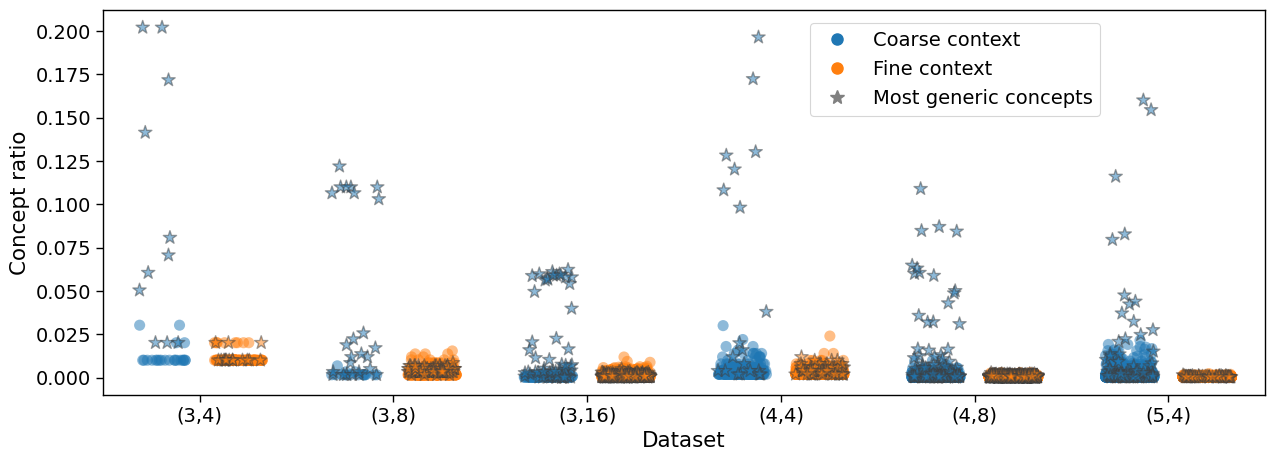

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.lines as mlines

# Prepare data for each dataset
all_ratios = []
granularity = []  # To store whether the ratio is 'Coarse' or 'Fine'
datasets_labels = []  # To store the dataset name
is_generic = []  # To store whether the concept is generic
sns.set_context("paper", font_scale=1.6)  # Adjust font_scale as needed


for i, dataset_name in enumerate(datasets):
    # Add coarse ratios
    if coarse_ratios[i]:
        all_ratios.extend(coarse_ratios[i])
        granularity.extend(['Coarse context'] * len(coarse_ratios[i]))
        datasets_labels.extend([dataset_name] * len(coarse_ratios[i]))
        is_generic.extend(coarse_generic_mask[i])  # Add mask values for coarse

    # Add fine ratios
    if fine_ratios[i]:
        all_ratios.extend(fine_ratios[i])
        granularity.extend(['Fine context'] * len(fine_ratios[i]))
        datasets_labels.extend([dataset_name] * len(fine_ratios[i]))
        is_generic.extend(fine_generic_mask[i])  # Add mask values for fine

# Combine data into a DataFrame for Seaborn
data = pd.DataFrame({
    'Ratio': all_ratios,
    'Granularity': granularity,
    'Dataset': datasets_labels,
    'Generic': is_generic  # Include the generic mask
})

# Count total points in each granularity condition per dataset
counts = data.groupby(['Dataset', 'Granularity']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(15, 5))


# Overlay with strip plots
sns.stripplot(
    x='Dataset', 
    y='Ratio', 
    hue='Granularity', 
    data=data[data['Generic'] == 0],  # Plot non-generic points first
    dodge=True, 
    marker="o",
    size=8, 
    alpha=0.5, 
    jitter=0.25  # Add jitter to better spread out the points
)

sns.stripplot(
    x='Dataset', 
    y='Ratio', 
    hue='Granularity',  # Prevents adding extra legend for generic points
    data=data[data['Generic'] == 1],  # Overlay generic points
    dodge=True, 
    marker="*",  # Use a star marker for generic points
    alpha=0.5, 
    size=10,  # Larger marker size for emphasis
    linewidth=1,
    jitter=0.25,
    legend=False  # Suppress legend creation for this plot
)

# Create a custom legend
coarse_circle = mlines.Line2D([], [], color='tab:blue', marker='o', linestyle='None', markersize=8, label='Coarse context')
fine_circle = mlines.Line2D([], [], color='tab:orange', marker='o', linestyle='None', markersize=8, label='Fine context')
star = mlines.Line2D([], [], color = 'gray', marker = '*',  markersize = 10, linestyle='None', label = 'Most generic concepts')


plt.legend(handles=[coarse_circle, fine_circle, star], loc='best', bbox_to_anchor=(0.6, 0.7))


plt.ylabel('Concept ratio')
plt.xlabel('Dataset')
plt.show()


## Visualisation -- Work in progress


In [9]:
import plotly.express as ex

In [13]:
import pandas as pd
import plotly.express as px
import ast
import random

def plot_sunburst(df_path, n_samples=3):
    # Step 1: Read the CSV file
    df = pd.read_csv(df_path)
    
    # Step 2: Convert string representations of lists to actual lists
    df['symbols'] = df['symbols'].apply(ast.literal_eval)
    df['message'] = df['message'].apply(ast.literal_eval)
    df['shared fixed attribute values'] = df['shared fixed attribute values'].apply(ast.literal_eval)
    
    df['shared fixed attribute values'] = df['shared fixed attribute values'].apply(lambda x: tuple(x))
    df = df.groupby('shared fixed attribute values', as_index= False).agg({'symbols': lambda x :tuple(x), 'message': lambda x :tuple(x) })
    fig = px.sunburst(
    data,
    names=df['shared_fixed_attribute_values'],
    parents=df['message'],
    values=df['symbols'],
    )   
    fig.show()
# Usage

plot_sunburst('analysis/lexica/(3,4)_granularity_coarse.csv')

KeyError: 'shared fixed attribute values'

In [17]:
import pandas as pd
import plotly.express as px
import ast
import random

def plot_sunburst(df_path, n_samples=3):
    # Step 1: Read the CSV file
    df = pd.read_csv(df_path)
    
    # Step 2: Convert string representations of lists to actual lists
    df['symbols'] = df['symbols'].apply(ast.literal_eval)
    df['message'] = df['message'].apply(ast.literal_eval)
    df['shared fixed attribute values'] = df['shared fixed attribute values'].apply(ast.literal_eval)
    
    # Convert 'shared fixed attribute values' to tuples for grouping
    df['shared fixed attribute values'] = df['shared fixed attribute values'].apply(lambda x: tuple(x))
    
    # Group by 'shared fixed attribute values' and aggregate 'symbols' and 'message' columns
    grouped_df = df.groupby('shared fixed attribute values', as_index=False).agg({
        'symbols': lambda x: tuple(x),
        'message': lambda x: tuple(x)
    })
    
    # Randomly select n_samples groups
    sample_groups = grouped_df.sample(n=n_samples)
    
    

# Usage
plot_sunburst('analysis/lexica/(3,4)_granularity_coarse.csv')


   shared fixed attribute values                 symbols  \
13                  ((3, _, _),)                ([{7}],)   
18                  ((_, 3, 1),)  ([{1, 12}], [{1, 12}])   
2                   ((0, 1, 1),)             ([{9, 3}],)   

                             message  
13                   ((7, 7, 7, 0),)  
18  ((1, 12, 12, 0), (12, 1, 12, 0))  
2                    ((9, 9, 3, 0),)  


### Fine context condition

In [127]:
import torch
import pandas as pd
import random

# Assuming these variables are already defined: datasets, paths, setting, non_default_gran_list, n_epochs, n_values, n_attributes


# Go through all datasets
for i, d in enumerate(datasets):
    path_to_run = paths[i] + '/' + str(setting) + '/granularity_fine' + '/' + str(0) + '/'
    
    path_to_interaction_train = path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0'
    path_to_interaction_val = path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0'
    interaction = torch.load(path_to_interaction_train)
    #print("Interaction train path:", path_to_interaction_train)

    messages = interaction.message.argmax(dim=-1)
    messages = [msg.tolist() for msg in messages]
    sender_input = interaction.sender_input
    #print("Sender input shape:", sender_input.shape)
    n_targets = int(sender_input.shape[1] / 2)
    
    # Get target objects and fixed vectors to re-construct concepts
    target_objects = sender_input[:, :n_targets]
    target_objects = k_hot_to_attributes(target_objects, n_values[i])
    # Concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
    (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
    concepts = list(zip(objects, fixed))
    #print(concepts[0])

   # Collect data for the DataFrame

    mess = []
    concept_reps= []

    for idx, (t_objects, t_fixed) in enumerate(concepts):
        #concept_sample = (tuple(t_objects[0]), tuple(t_fixed))
        concept_sample = (
                list(int(x) for x in t_objects[0]), 
                list(int(x) for x in t_fixed)
            )
        mess.append(tuple(messages[idx]))
        concept_reps.append(create_alternative_representation(concept_sample))

    # Create the DataFrame
    df = pd.DataFrame({'concepts': concept_reps, 'message': mess})
    concept_df = df.groupby('concepts').agg({'message': lambda x: list(x)})
    print(concept_df.shape)

    # Group by messages and aggregate concepts
    message_df = df.groupby('message', as_index=False).agg({'concepts': lambda x: list(x)})
    message_df.to_csv('analysis/messages/'+str(d) + '_' + str(setting) + '_granularity_fine.csv', index=False)
    

(99, 1)
(582, 1)
(3929, 1)
(499, 1)
(5248, 1)
(2499, 1)


In [128]:
for d in datasets:
    df = pd.read_csv('analysis/messages/'+d+'_standard_granularity_fine.csv')
 
    concepts = []
    mess = []
    lens = []
    for row in df.itertuples():
        concepts.append(concepts_for_message(df, [row[1]]))
        lens.append(len(concepts_for_message(df, [row[1]])))
        mess.append(row[1])

    res = pd.DataFrame({'message':mess, 'n_concepts': lens })
    res.to_csv('analysis/lexica/counts_'+d+'_granularity_fine.csv', index=False)
